In [1]:
# Importing
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
import numpy as np
from scipy import stats
from statsmodels.iolib.summary2 import summary_col
from math import exp, factorial
import statsmodels.formula.api as smf

import warnings
warnings.filterwarnings('ignore')


In [2]:
##############################################################################
#                          LOADING corruption DATASET                        #
##############################################################################

#Fisman, R.; Miguel, E. Corruption, Norms, and Legal Enforcement:
#Evidence from Diplomatic Parking Tickets.
#Journal of Political Economy, v. 15, n. 6, p. 1020-1048, 2007.
#https://www.journals.uchicago.edu/doi/abs/10.1086/527495

df_corruption = pd.read_csv('corruption.csv', delimiter=',')
df_corruption

#Dataset's variables characteristics
df_corruption.info()

#Univariate distribution
df_corruption.describe()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 298 entries, 0 to 297
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   country     298 non-null    object 
 1   code        298 non-null    object 
 2   violations  298 non-null    int64  
 3   staff       298 non-null    int64  
 4   post        298 non-null    object 
 5   corruption  298 non-null    float64
dtypes: float64(1), int64(2), object(3)
memory usage: 14.1+ KB


,violations,staff,corruption
count,298.000000,298.000000,298.000000
mean,6.496644,11.805369,0.013641
std,18.210377,11.079558,1.012474
min,0.000000,2.000000,-2.582988
25%,0.000000,6.000000,-0.415147
50%,0.000000,9.000000,0.326959
75%,3.000000,14.000000,0.720250
max,167.000000,86.000000,1.582807


In [3]:
# Frequency table for the variable 'violations'

contagem = df_corruption['violations'].value_counts(dropna=False)
percent = df_corruption['violations'].value_counts(dropna=False, normalize=True)
pd.concat([contagem, percent], axis=1, keys=['contagem', '%'], sort=True)

,contagem,%
0,156,0.523490
1,35,0.117450
2,16,0.053691
3,17,0.057047
4,5,0.016779
5,10,0.033557
6,3,0.010067
7,4,0.013423
8,3,0.010067
9,3,0.010067


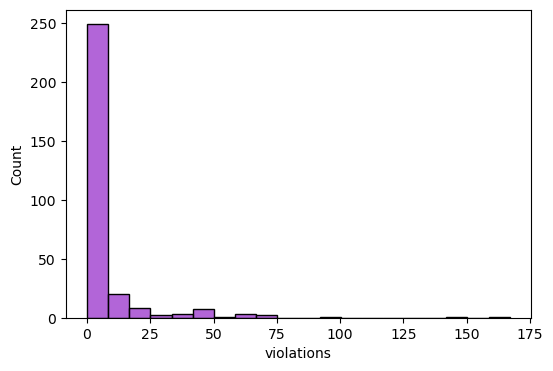

In [4]:
# Histogram for 'violations'

plt.figure(figsize=(6,4))
sns.histplot(data=df_corruption, x="violations", bins=20, color='darkorchid')
plt.show()

In [5]:
# Comparison between Mean and Variance, for the 'corruption' dataset

pd.DataFrame({'Mean':[df_corruption.violations.mean()],
              'Variance':[df_corruption.violations.var()]})

,Mean,Variance
0,6.496644,331.617834


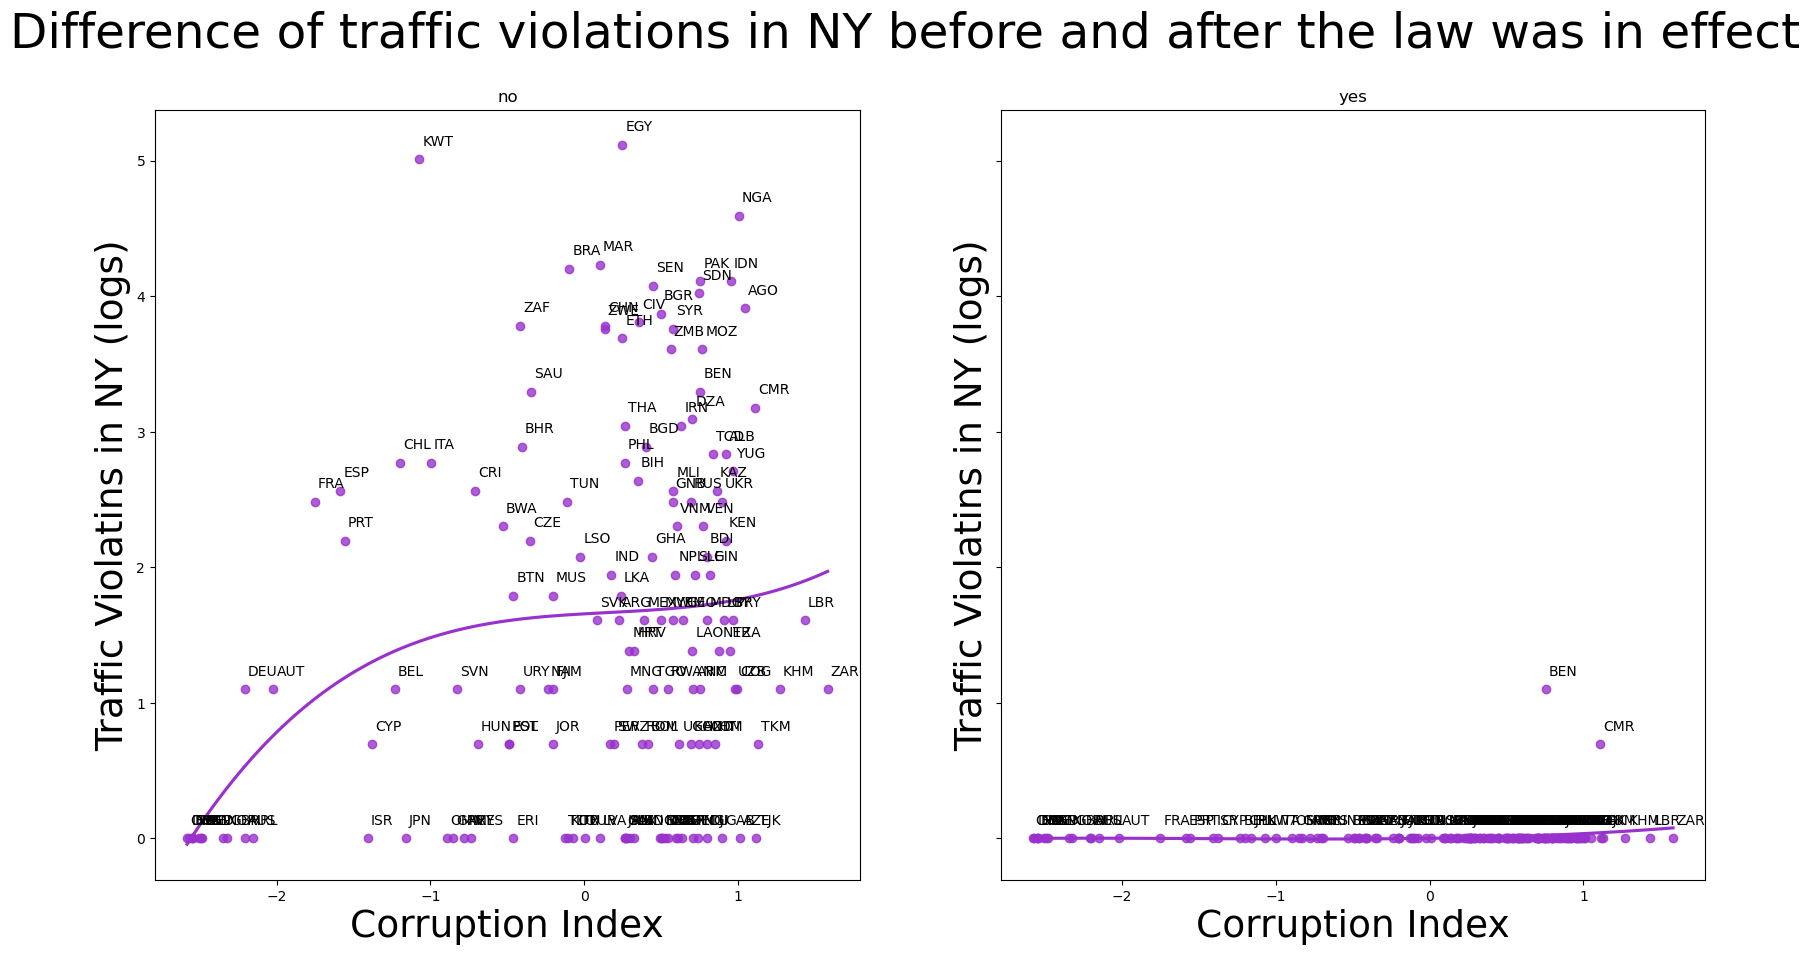

In [6]:
# Behavior of the variables 'corruption' and 'violations' before and after the beginning of the law

fig, axs = plt.subplots(ncols=2, figsize=(20,10), sharey=True)

fig.suptitle('Difference of traffic violations in NY before and after the law was in effect',
             fontsize = 35)

post = ['no','yes']

def label_point(x, y, val, ax):
    a = pd.concat({'x': x, 'y': y, 'val': val}, axis=1)
    for i, point in a.iterrows():
        ax.text(point['x']+.02, point['y']+.1, str(point['val']))

for i, v in enumerate(post):
    df = df_corruption[df_corruption.post==v]
    df['violations'] = np.log(df.violations)
    df.loc[df['violations']==np.inf, 'violations'] = 0
    df.loc[df['violations']==-np.inf, 'violations'] = 0
    sns.regplot(data=df, x='corruption', y='violations',order=3, ax=axs[i],
                ci=False, color='darkorchid')
    axs[i].set_title(v)
    axs[i].set_ylabel("Traffic Violatins in NY (logs)", fontsize = 27)
    axs[i].set_xlabel("Corruption Index", fontsize = 27)
    label_point(df.corruption, df.violations, df.code, axs[i])  

plt.show()

In [7]:
# Poisson model (we could skip this step, because the mean is completely different from the variance)

modelo_poisson = smf.glm(formula='violations ~ staff + post + corruption',
                         data=df_corruption,
                         family=sm.families.Poisson()).fit()

#Model's Parameters
modelo_poisson.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:             violations   No. Observations:                  298
Model:                            GLM   Df Residuals:                      294
Model Family:                 Poisson   Df Model:                            3
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -2071.8
Date:                Thu, 06 Apr 2023   Deviance:                       3644.0
Time:                        11:22:59   Pearson chi2:                 6.77e+03
No. Iterations:                     7   Pseudo R-squ. (CS):             0.9999
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept       2.2127      0.031     71.134      0.000       2.152       2.274
post[T.yes]    -4.2968      0.197    -21.762      0.000      -4.684      -3.910
staff           0.0219      0.001     17.807      0.000       0.019       0.024
corruption      0.3418      0.027     12.430      0.000       0.288       0.396
===============================================================================
"""

In [8]:
summary_col([modelo_poisson],
            model_names=["POISSON MODEL"],
            stars=True,
            info_dict = {
                'N':lambda x: "{0:d}".format(int(x.nobs)),
                'Log-lik':lambda x: "{:.2f}".format(x.llf)
        })


,POISSON MODEL
Intercept,2.2127***
,(0.0311)
post[T.yes],-4.2968***
,(0.1974)
staff,0.0219***
,(0.0012)
corruption,0.3418***
,(0.0275)
N,298
Log-lik,-2071.79


In [9]:
################################################################################
#                   OVERDISPERSION TEST CAMERON & TRIVEDI (1990)               #
################################################################################
#CAMERON, A. C.; TRIVEDI, P. K. Regression-based tests for overdispersion in
#the Poisson model. Journal of Econometrics, v. 46, n. 3, p. 347-364, 1990.

# Authors: Luiz Paulo Fávero e Helder Prado Santos
# https://stats-tests.github.io/statstests/
!pip install statstests
from statstests.tests import overdisp

#Elaboração direta do teste de superdispersão
overdisp(modelo_poisson, df_corruption)



Estimating model...: 
 GLM
                        Results: Ordinary least squares
Model:                  OLS              Adj. R-squared (uncentered): 0.022    
Dependent Variable:     ystar            AIC:                         3907.7809
Date:                   2023-04-06 11:23 BIC:                         3911.4780
No. Observations:       298              Log-Likelihood:              -1952.9  
Df Model:               1                F-statistic:                 7.584    
Df Residuals:           297              Prob (F-statistic):          0.00625  
R-squared (uncentered): 0.025            Scale:                       28915.   
-------------------------------------------------------------------------------------
            Coef.        Std.Err.         t          P>|t|        [0.025       0.975]
-------------------------------------------------------------------------------------
lmbda       2.6525         0.9632       2.7538       0.0063       0.7569       4.5480
-------------

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:             violations   No. Observations:                  298
Model:                            GLM   Df Residuals:                      294
Model Family:        NegativeBinomial   Df Model:                            3
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -567.40
Date:                Thu, 06 Apr 2023   Deviance:                       239.14
Time:                        11:25:07   Pearson chi2:                     466.
No. Iterations:                    18   Pseudo R-squ. (CS):             0.6714
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept       1.9469      0.162     12.050      0.000       1.630       2.264
post[T.yes]    -4.2746      0.266    -16.071      0.000      -4.796      -3.753
staff           0.0400      0.009      4.497      0.000       0.023       0.057
corruption      0.4527      0.115      3.950      0.000       0.228       0.677
===============================================================================
"""

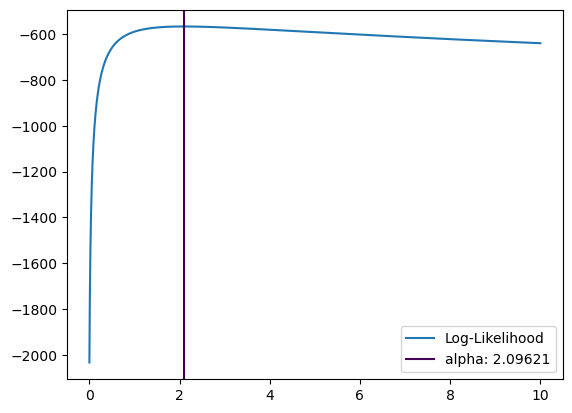

In [10]:
##############################################################################
#                               NEGATIVE BINOMIAL                            #
##############################################################################


modelo_bneg = smf.glm(formula='violations ~ staff + post + corruption',
                      data=df_corruption,
                      family=sm.families.NegativeBinomial(alpha=2.0963)).fit()

#Model's parameters
modelo_bneg.summary()

#"alpha" definition
n_samples = 10000
alphas = np.linspace(0, 10, n_samples)
llf = np.full(n_samples, fill_value=np.nan)
for i, alpha in enumerate(alphas):
    try:
        model = smf.glm(formula = 'violations ~ staff + post + corruption',
                        data=df_corruption,
                        family=sm.families.NegativeBinomial(alpha=alpha)).fit()
    except:
        continue
    llf[i] = model.llf
alpha_ótimo = alphas[np.nanargmax(llf)]
alpha_ótimo

#results plot
plt.plot(alphas, llf, label='Log-Likelihood')
plt.axvline(x=alpha_ótimo, color='#440154FF',
            label=f'alpha: {alpha_ótimo:0.5f}')
plt.legend()

#Model estimation, considering the optimum 'alpha' parameter
modelo_bneg = smf.glm(formula='violations ~ staff + post + corruption',
                      data=df_corruption,
                      family=sm.families.NegativeBinomial(alpha=alpha_ótimo)).fit()

summary_col([modelo_bneg],
            model_names=["NEGATIVE BINOMIAL MODEL"],
            stars=True,
            info_dict = {
                'N':lambda x: "{0:d}".format(int(x.nobs)),
                'Log-lik':lambda x: "{:.2f}".format(x.llf)
        })


#Model's parameter
modelo_bneg.summary()


In [11]:
# Comparison between Poisson and neg binomial

summary_col([modelo_poisson, modelo_bneg], 
            model_names=["Poisson","BNeg"],
            stars=True,
            info_dict = {
                'N':lambda x: "{0:d}".format(int(x.nobs)),
                'Log-lik':lambda x: "{:.2f}".format(x.llf),
                'Pseudo-R2':lambda x: "{:.4f}".format(x.pseudo_rsquared()),
        })



,Poisson,BNeg
Intercept,2.2127***,1.9469***
,(0.0311),(0.1616)
post[T.yes],-4.2968***,-4.2746***
,(0.1974),(0.2660)
staff,0.0219***,0.0400***
,(0.0012),(0.0089)
corruption,0.3418***,0.4527***
,(0.0275),(0.1146)
N,298,298
Log-lik,-2071.79,-567.40


In [12]:
# Adding the fitted values to the dataset (for comparison)

df_corruption['fitted_poisson'] = modelo_poisson.fittedvalues
df_corruption['fitted_bneg'] = modelo_bneg.fittedvalues

df_corruption[['country','code','violations','fitted_poisson','fitted_bneg']]


,country,code,violations,fitted_poisson,fitted_bneg
0,Angola,AGO,50,15.919915,16.138591
1,Angola,AGO,1,0.216711,0.224603
2,Albania,ALB,17,13.371720,11.987629
3,Albania,ALB,0,0.182023,0.166834
4,United Arab Emirates,ARE,0,7.477915,5.551769
...,...,...,...,...,...
293,Zaire,ZAR,0,0.243691,0.253810
294,Zambia,ZMB,37,13.486751,12.955687
295,Zambia,ZMB,0,0.183589,0.180306
296,Zimbabwe,ZWE,43,12.994217,13.033499


In [13]:
##############################################################################
#                     ZERO-INFLATED POISSON (ZIP) MODEL                      #
##############################################################################

# 'Y' Defining
y = df_corruption.violations

# Defining which variables will be in the counting component
x1 = df_corruption[['staff','post','corruption']]
X1 = sm.add_constant(x1)

#Defining which variables will be in the logit (inflate) component
x2 = df_corruption[['corruption']]
X2 = sm.add_constant(x2)

#dummying the qualitative variable
X1 = pd.get_dummies(X1, columns=['post'], drop_first=True)

#Estimação do modelo ZIP
#'exog_infl' = 'logit'
modelo_zip = sm.ZeroInflatedPoisson(y, X1, exog_infl=X2,
                                    inflation='logit').fit()

#Model's parameters
modelo_zip.summary()


Optimization terminated successfully.
         Current function value: 5.977545
         Iterations: 22
         Function evaluations: 27
         Gradient evaluations: 27


<class 'statsmodels.iolib.summary.Summary'>
"""
                     ZeroInflatedPoisson Regression Results                    
===============================================================================
Dep. Variable:              violations   No. Observations:                  298
Model:             ZeroInflatedPoisson   Df Residuals:                      294
Method:                            MLE   Df Model:                            3
Date:                 Thu, 06 Apr 2023   Pseudo R-squ.:                  0.1975
Time:                         11:25:07   Log-Likelihood:                -1781.3
converged:                        True   LL-Null:                       -2219.8
Covariance Type:             nonrobust   LLR p-value:                8.828e-190
======================================================================================
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
inflate_const         -1.6116      0.240     -6.714      0.000      -2.082      -1.141
inflate_corruption    -0.9523      0.195     -4.875      0.000      -1.335      -0.569
const                  2.4889      0.032     78.990      0.000       2.427       2.551
staff                  0.0200      0.001     16.154      0.000       0.018       0.022
corruption             0.0937      0.030      3.127      0.002       0.035       0.152
post_yes              -4.2879      0.201    -21.291      0.000      -4.683      -3.893
======================================================================================
"""

In [14]:
# Comparison between Poisson and ZIP

summary_col([modelo_poisson, modelo_zip], 
            model_names=["Poisson","ZIP"],
            stars=True,
            info_dict = {
                'N':lambda x: "{0:d}".format(int(x.nobs)),
                'Log-lik':lambda x: "{:.2f}".format(x.llf),
                'Pseudo-R2':lambda x: "{:.4f}".format(x.pseudo_rsquared()),
        })

,Poisson,ZIP
Intercept,2.2127***,
,(0.0311),
const,,2.4889***
,,(0.0315)
corruption,0.3418***,0.0937***
,(0.0275),(0.0300)
inflate_const,,-1.6116***
,,(0.2401)
inflate_corruption,,-0.9523***
,,(0.1954)


In [15]:
# likelihood ratio test

def lrtest(modelos):
    modelo_1 = modelos[0]
    llk_1 = modelo_1.llnull
    llk_2 = modelo_1.llf
    
    if len(modelos)>1:
        llk_1 = modelo_1.llf
        llk_2 = modelos[1].llf
    LR_statistic = -2*(llk_1-llk_2)
    p_val = stats.chi2.sf(LR_statistic, 1)
    return round(LR_statistic,2), round(p_val,2)

lrtest([modelo_poisson, modelo_zip])

(580.97, 0.0)

In [16]:
##############################################################################
#             ESTIMATING THE ZERO-INFLATED BINOMIAL NEGATIVO (ZINB)          #
##############################################################################

#Defining Y
y = df_corruption.violations

# Defining which variables will be in the counting component
x1 = df_corruption[['staff','post','corruption']]
X1 = sm.add_constant(x1)

#Defining which variables will be in the logit (inflate) component
x2 = df_corruption[['corruption']]
X2 = sm.add_constant(x2)

#dummying qualitative variables
X1 = pd.get_dummies(X1, columns=['post'], drop_first=True)

#ZINB model:

from statsmodels.discrete.count_model import ZeroInflatedNegativeBinomialP
modelo_zinb = ZeroInflatedNegativeBinomialP(y, X1, exog_infl=X2,
                                            inflation='logit').fit()

#Model's parameters
modelo_zinb.summary()



         Current function value: 1.870015
         Iterations: 35
         Function evaluations: 39
         Gradient evaluations: 39


<class 'statsmodels.iolib.summary.Summary'>
"""
                     ZeroInflatedNegativeBinomialP Regression Results                    
=========================================================================================
Dep. Variable:                        violations   No. Observations:                  298
Model:             ZeroInflatedNegativeBinomialP   Df Residuals:                      294
Method:                                      MLE   Df Model:                            3
Date:                           Thu, 06 Apr 2023   Pseudo R-squ.:                  0.1700
Time:                                   11:25:07   Log-Likelihood:                -557.26
converged:                                 False   LL-Null:                       -671.37
Covariance Type:                       nonrobust   LLR p-value:                 3.353e-49
======================================================================================
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
inflate_const        -17.9857      9.287     -1.937      0.053     -36.187       0.216
inflate_corruption    -8.1104      4.037     -2.009      0.045     -16.023      -0.197
const                  2.0324      0.203      9.988      0.000       1.634       2.431
staff                  0.0411      0.013      3.078      0.002       0.015       0.067
corruption             0.1815      0.147      1.237      0.216      -0.106       0.469
post_yes              -4.2638      0.261    -16.328      0.000      -4.776      -3.752
alpha                  1.8560      0.218      8.518      0.000       1.429       2.283
======================================================================================
"""

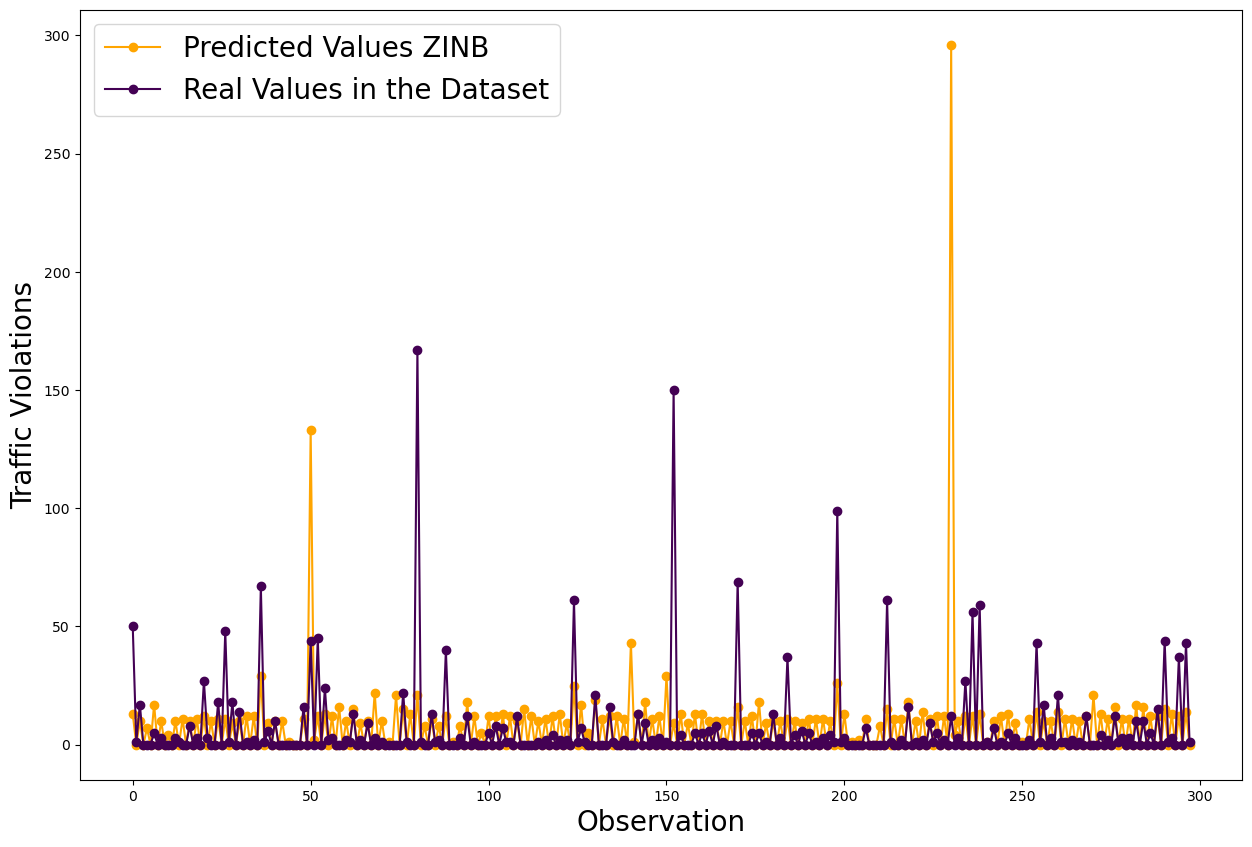

In [17]:
# Comparison plot predicted x real ZINB model

zinb_predictions = modelo_zinb.predict(X1, exog_infl=X2)
predicted_counts = np.round(zinb_predictions)
actual_counts = df_corruption['violations']

plt.figure(figsize=(15,10))
plt.plot(df_corruption.index, predicted_counts, 'go-',
         color='orange')
plt.plot(df_corruption.index, actual_counts, 'go-',
         color='#440154FF')
plt.xlabel('Observation', fontsize=20)
plt.ylabel('Traffic Violations', fontsize=20)
plt.legend(['Predicted Values ZINB', 'Real Values in the Dataset'],
           fontsize=20)
plt.show()

In [18]:
# Comparison between BNeg and ZINB

summary_col([modelo_bneg, modelo_zinb], 
            model_names=["BNeg","ZINB"],
            stars=True,
            info_dict = {
                'N':lambda x: "{0:d}".format(int(x.nobs)),
                'Log-lik':lambda x: "{:.2f}".format(x.llf),
                'Pseudo-R2':lambda x: "{:.4f}".format(x.pseudo_rsquared()),
        })

,BNeg,ZINB
Intercept,1.9469***,
,(0.1616),
alpha,,1.8560***
,,(0.2179)
const,,2.0324***
,,(0.2035)
corruption,0.4527***,0.1815
,(0.1146),(0.1466)
inflate_const,,-17.9857*
,,(9.2867)


In [19]:
# likelihood ratio test
def lrtest(modelos):
    modelo_1 = modelos[0]
    llk_1 = modelo_1.llnull
    llk_2 = modelo_1.llf
    
    if len(modelos)>1:
        llk_1 = modelo_1.llf
        llk_2 = modelos[1].llf
    LR_statistic = -2*(llk_1-llk_2)
    p_val = stats.chi2.sf(LR_statistic, 1)
    return round(LR_statistic,2), round(p_val,2)

lrtest([modelo_bneg, modelo_zinb])


(20.27, 0.0)

Text(0.5, 0, 'Log-Likehood')

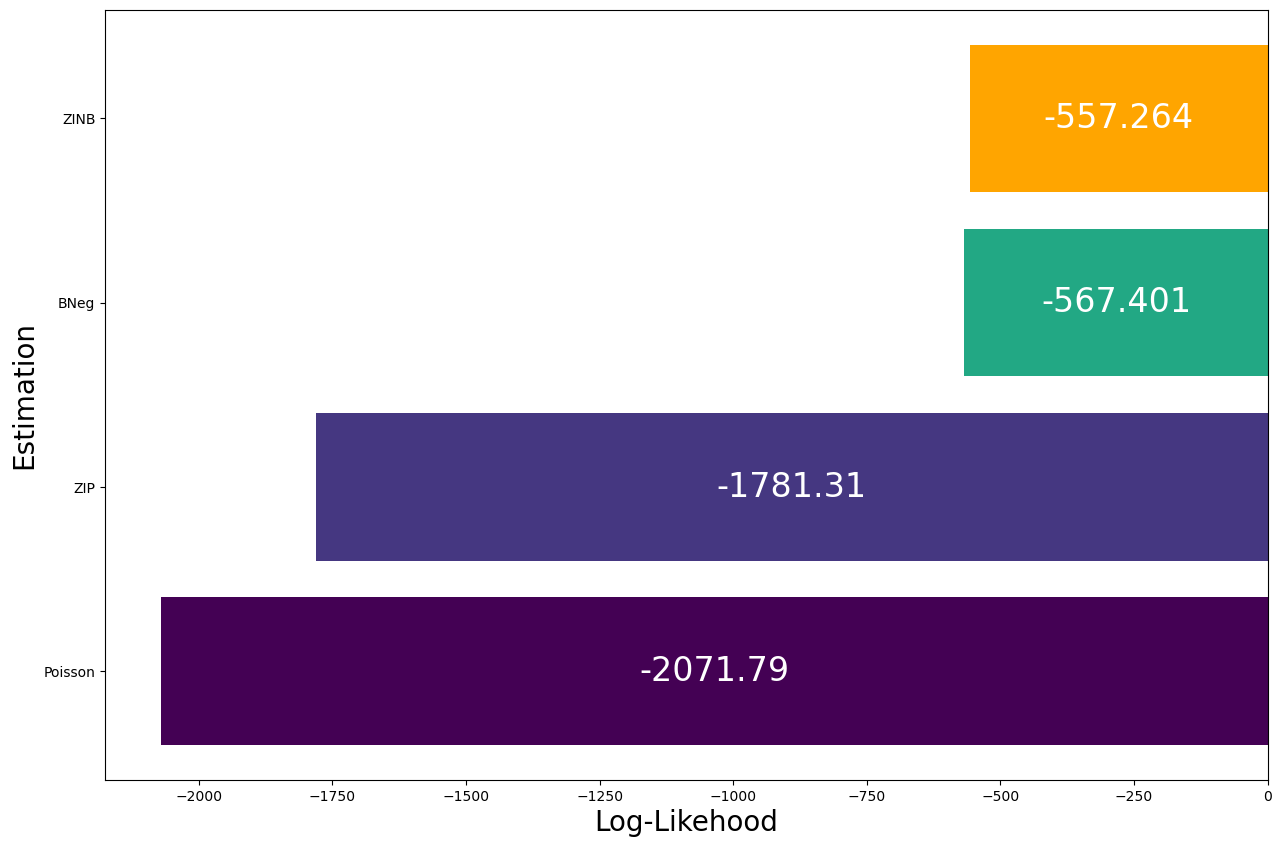

In [20]:
# Plot

df_llf = pd.DataFrame({'modelo':['Poisson','ZIP','BNeg','ZINB'],
                      'loglik':[modelo_poisson.llf,
                                modelo_zip.llf,
                                modelo_bneg.llf,
                                modelo_zinb.llf]})
df_llf

fig, ax = plt.subplots(figsize=(15,10))

c = ["#440154FF", "#453781FF", "#22A884FF", "orange"]

ax1 = ax.barh(df_llf.modelo, df_llf.loglik, color = c)
ax.bar_label(ax1, label_type='center', color='white', fontsize=24)
ax.set_ylabel("Estimation", fontsize=20)
ax.set_xlabel("Log-Likehood", fontsize=20)

In [21]:
# Adicionando os fitted values dos modelos estimados para fins de
#comparação

df_corruption['fitted_zip'] = modelo_zip.predict(X1, exog_infl=X2)
df_corruption['fitted_zinb'] = modelo_zinb.predict(X1, exog_infl=X2)
df_corruption




,country,code,violations,staff,post,corruption,fitted_poisson,fitted_bneg,fitted_zip,fitted_zinb
0,Angola,AGO,50,9,no,1.047506,15.919915,16.138591,14.823562,13.358543
1,Angola,AGO,1,9,yes,1.047506,0.216711,0.224603,0.203580,0.187939
2,Albania,ALB,17,3,no,0.921079,13.371720,11.987629,12.877979,10.203814
3,Albania,ALB,0,3,yes,0.921079,0.182023,0.166834,0.176860,0.143555
4,United Arab Emirates,ARE,0,3,no,-0.779468,7.477915,5.551769,8.379367,7.494531
...,...,...,...,...,...,...,...,...,...,...
293,Zaire,ZAR,0,6,yes,1.582807,0.243691,0.253810,0.207250,0.183098
294,Zambia,ZMB,37,9,no,0.562193,13.486751,12.955687,13.616058,12.232444
295,Zambia,ZMB,0,9,yes,0.562193,0.183589,0.180306,0.186996,0.172096
296,Zimbabwe,ZWE,43,14,no,0.133379,12.994217,13.033499,13.732195,13.896783


<function matplotlib.pyplot.show(close=None, block=None)>

<Figure size 2000x1000 with 0 Axes>

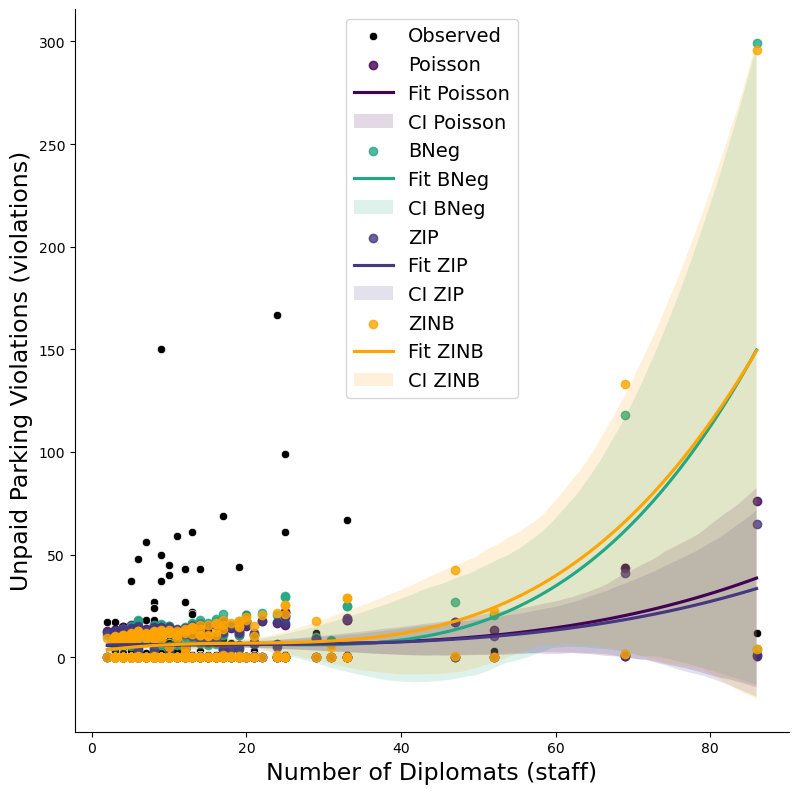

In [23]:
# Fitted values dos modelos POISSON, BNEG, ZIP e ZINB, considerando,
#para fins didáticos, a variável dependente 'violations' em função apenas da
#variável preditora 'staff'

plt.figure(figsize=(20,10))
sns.relplot(data=df_corruption, x='staff', y='violations',
            color='black', height=8)
sns.regplot(data=df_corruption, x='staff', y='fitted_poisson', order=3,
            color='#440154FF')
sns.regplot(data=df_corruption, x='staff', y='fitted_bneg', order=3,
            color='#22A884FF')
sns.regplot(data=df_corruption, x='staff', y='fitted_zip', order=3,
            color='#453781FF')
sns.regplot(data=df_corruption, x='staff', y='fitted_zinb', order=3,
            color='orange')
plt.xlabel('Number of Diplomats (staff)', fontsize=17)
plt.ylabel('Unpaid Parking Violations (violations)', fontsize=17)
plt.legend(['Observed', 'Poisson', 'Fit Poisson', 'CI Poisson',
            'BNeg', 'Fit BNeg', 'CI BNeg',
            'ZIP', 'Fit ZIP', 'CI ZIP',
            'ZINB', 'Fit ZINB', 'CI ZINB'],
           fontsize=14)
plt.show


################################## FIM ######################################